<a href="https://colab.research.google.com/github/mike1336git/colab_notebook/blob/main/with_js/js096_H2MoleculeDMC3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### simulator( html + css + js ) + control( python )

In [ ]:
#@title js096_H2MoleculeDMC3D / def exec_html_js() ... exec me first

# def exec_html_js()

import IPython
from IPython.display import display, HTML
from google.colab.output import eval_js

def exec_html_js():
  htm = HTML('''


<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<title>js096_H2MoleculeDMC3D</title>
<script type="text/javascript">

// %%%%%%%%%%%%%%%%%%%%  javaScript  %%%%%%%%%%%%%%%%%%%%

'use strict';

/* --------------------
//
//  js096_H2MoleculeDMC3D
//    Copyright(C) 2018 Mitsuru Ikeuchi
//    Released under the MIT license ( https://opensource.org/licenses/MIT )
//
//    ver 0.0.0  2018.03.18 created, last updated on 2018.12.03
//    ver 0.0.1  2019.01.25 v1, last updated on 2021.09.06
//    ver 0.0.2  2021.11.06 v2, last updated on 2021.11.06
//    ver 0.0.3  2023.05.07 v3, last updated on 2023.09.07
//
// -------------------- diffusion Monte-Carlo method 3D
//
//  diffusion Monte-Carlo method
//
// DMC algorithm : I. Kosztin et. al.; e-print arXiv:physics/9702023v1 (1997)
//                 "Introduction to the Diffusion Monte Carlo Method"
// (1) replica walk
//     x -> x + sqrt(dt)*GaussianRandom
// (2) branch: replica birth-death (branching) processes
//     weight function W
//       W = exp( -(V-ER)*dt/hbar ) --> Wi nearly= 1-(Vi-Ei)*dt/h
//       m = int( wi + random[0-1] )
//     if (m=0)  death
//     if (m=1)  alive
//     if (m=2)  alive + birth one replica
//     if (m>=3) alive + birth two replica
// (3) count: number of replicas N1
// (4) energy calc
//     ER(k+1) = ER(k) + (hbar/dt)(1-N1/N0)
//        (N0: target number of replica)
// goto (1)
//
//
// minimum energy interatomic distance
//
//  H2+ ion       1.057e-10 m ~ 2.0 au
//  H2  molecule  0.740e-10 m ~ 1.4 au
//
// --------------------
*/

const H2MoleculeDMC3D = (function(){ // ====================  H2MoleculeDMC3D Module  ====================

	// au: atomic unit hBar=1,e=1,me=1,a0=1
	const g_auLength = 5.29177211e-11;			// (m) 1(au) = g_auLength (m)
	const g_auTime = 2.418884326e-17;			// (s) 1(au) = g_auTime (s)
	const g_auEnergy = 4.35974465e-18;			// (J) 1(au) = auEnergy (J)
	const g_au2eV = 27.211386;					// (eV) 1(au) = 27.211386 (eV)
	const g_hbar = 1.0;							// hbar = 1 in au(atomic unit)

	const g_rMin = 1.0e-15/g_auLength;			// g_rMin nearly= proton size
	const g_NNrep = 2000;						// max number of replicant
	const g_NNpMax = 2;							// max number of nucleus
	const g_NNdim = 3;							// 3D (0:x, 1:y, 2:z)
	const g_Ndiv = 40;							// max number of space division

	let g_dmcCount = 0;							// system count
	let g_sysTime = 0.0;						// (au)
	let g_deltaTau = 0.1;						// (au) H:0.1, He:0.05
	let g_NN0 = 1000;							// memory of g_NN1
	let g_NN1 = g_NN0;							// number of alive replicas
	let g_NN00 = g_NN0;							// initial number of alive replicas
	let g_referenceEnergy = 0.0;				// (au) reference energy of the system
	let g_averagedReferenceEnergy = g_referenceEnergy; // (au) averaged reference energy
	let g_averageCount = 1000;					// average count
	let g_averageFactor = 1.0/g_averageCount;	// = 1.0/g_averageCount  eg. 1/1000 1/10000
	let g_dPP = 1.40;							// (au)H-H distance
	let g_sysEnergy = g_averagedReferenceEnergy + 1/g_dPP; // (au) aletaged system reference energy
	let g_sysEnergy10000 = g_sysEnergy;
	let g_potential = potentialH2Molecule;		// function potentialH2Molecule(i)
	let g_NNe = 2;								// number of electron
	let g_NNp = 2;								// number of proton
	let g_themeStr = "H2 molecule";

	let g_average1000 = 0.0;
	let g_average10000 = 0.0;

	// 3D graphics (DMC) interface
	var g_NNx=g_Ndiv, g_NNy=g_Ndiv, g_NNz=g_Ndiv, g_dx=0.5,g_dy=0.5,g_dz=0.5;

	const g_repStatus = dimInt1( g_NNrep );					// 0-not alive, 1-alive, 2-birth mark
	const g_replica = dim3( g_NNrep, g_NNpMax, g_NNdim );	// g_replica[replica][particle][0:x 1:y 2:z]
	const g_psiDensity = dim3( g_Ndiv, g_Ndiv, g_Ndiv );	// wave function psi[ix][iy][iy]
	const g_box = dim3( g_Ndiv, g_Ndiv, g_Ndiv );			// g_box[ix][iy][iz] number of replica

	function dimInt1( n ) {
		return new Int32Array( n );
	}

	function dim3( ni, nj, nk ) {
		let a = [];
		for (let i=0; i<ni; i++) {
			a[i] = [];
			for (let j=0; j<nj; j++) {
				a[i][j] = new Float64Array( nk );
			}
		}
		return a;
	}


	// --------------------  theme table  --------------------

	const g_themeTable = [
	//   0:theme 1:NNe 2:NNp 3:potential             4:themeStr
		[  0,     1,    1,    potentialHAtom,         "H atom"       ],
		[  1,     2,    1,    potentialHeAtom,        "He atom"      ],
		[  2,     1,    2,    potentialH2PositiveIon, "H2+ ion"      ],
		[  3,     2,    2,    potentialH2Molecule,    "H2 molecule"  ],
		[  4,     1,    1,    potentialParabolic,     "hermonics"    ],
		[  5,     1,    1,    potentialSphereWell,    "sphereWell"   ]
	]


	// --------------------  set initial condition  --------------------

	function setInitialCondition( theme ) {
		let themeNum;
		[ themeNum, g_NNe, g_NNp, g_potential, g_themeStr ] = g_themeTable[theme];

		g_sysTime = 0.0;
		g_dmcCount = 0;
		setInitialReplica();
		g_NN0 = numberOfReplica();
		g_NN00 = g_NN0;
		g_NN1 = g_NN0;
		g_referenceEnergy = averagedPotential();
		g_averagedReferenceEnergy = 0.0;
		clearPsiDensity();
	}

	function setInitialReplica() {
		const nn=g_NNrep, nne=g_NNe, nndim=g_NNdim;

		for (let i=0; i<nn; i++) {
			g_repStatus[i] = 0;
		}

		const n0 = nn/2;
		for (let i=0; i<n0; i++) {
			g_repStatus[i] = 1;
			for (let jp=0; jp<nne; jp++) {
				for (let jd=0; jd<nndim; jd++) {
					g_replica[i][jp][jd] = 4.0*(Math.random()-0.5);
				}
			}
		}
	}


	// --------------------  potential  --------------------

	function averagedPotential() {
		const nn=g_NNrep;
		let n=0, s=0.0;

		for (let i=0; i<nn; i++) {
			if (g_repStatus[i]==1) {
				n += 1;
				s += g_potential(i);
			}
		}
		return s/n;
	}

	// H atom : V(r,R) = -1/|r|
	function potentialHAtom(i) {
		const x = g_replica[i][0][0], y = g_replica[i][0][1], z = g_replica[i][0][2];
		let r2 = x*x+y*y+z*z; if (r2<g_rMin) r2=g_rMin;
		return( -1.0/Math.sqrt(r2) );
	}

	// He Atom :  V(r1,r2,R) = -2/|r1-R|-2/|r2-R| +1/|r1-r2|
	function potentialHeAtom(i) {
		const x1 = g_replica[i][0][0], y1 = g_replica[i][0][1], z1 = g_replica[i][0][2];
		const x2 = g_replica[i][1][0], y2 = g_replica[i][1][1], z2 = g_replica[i][1][2];

		let r12 = x1*x1+y1*y1+z1*z1; // (r1-R)^2
		if (r12<g_rMin) r12=g_rMin;
		let r22 = x2*x2+y2*y2+z2*z2; // (r2-R)^2
		if (r22<g_rMin) r22=g_rMin;
		let r32 = (x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2); // (r1-r2)^2
		if (r32<g_rMin) r32=g_rMin;
		return(-2.0/Math.sqrt(r12)-2.0/Math.sqrt(r22)+1.0/Math.sqrt(r32));
	}

	// H2+ ion :  V(r,R1,R2) = -1/|r-R1|-1/|r-R2|
	function potentialH2PositiveIon(i) {
		const rr = g_dPP; // R1=(0.5*g_dPP,0,0), R2=(-0.5*g_dPP,0,0)
		const x = g_replica[i][0][0], y = g_replica[i][0][1], z = g_replica[i][0][2];

		let r12 = (x-0.5*rr)*(x-0.5*rr)+y*y+z*z; // (r-R1)^2
		if (r12<g_rMin) r12=g_rMin;
		let r22 = (x+0.5*rr)*(x+0.5*rr)+y*y+z*z; // (r-R2)^2
		if (r22<g_rMin) r22=g_rMin;
		return(-1.0/Math.sqrt(r12)-1.0/Math.sqrt(r22));
	}

	// H2 molecule :  V(r1,r2,R1,R2) = sum(-1/|ri-Rj|,{i,j=1,2}) + 1/|r1-r2|
	function potentialH2Molecule(i) {
		const rr = g_dPP; // R1=(0.5*g_dPP,0,0), R2=(-0.5*g_dPP,0,0)
		const x1 = g_replica[i][0][0], y1 = g_replica[i][0][1], z1 = g_replica[i][0][2];
		const x2 = g_replica[i][1][0], y2 = g_replica[i][1][1], z2 = g_replica[i][1][2];

		let r12 = (x1-0.5*rr)*(x1-0.5*rr)+y1*y1+z1*z1; // (r1-R1)^2
		if (r12<g_rMin) r12=g_rMin;
		let r22 = (x1+0.5*rr)*(x1+0.5*rr)+y1*y1+z1*z1; // (r1-R2)^2
		if (r22<g_rMin) r22=g_rMin;
		let r32 = (x2-0.5*rr)*(x2-0.5*rr)+y2*y2+z2*z2; // (r2-R1)^2
		if (r32<g_rMin) r32=g_rMin;
		let r42 = (x2+0.5*rr)*(x2+0.5*rr)+y2*y2+z2*z2; // (r2-R2)^2
		if (r42<g_rMin) r42=g_rMin;
		let r52 = (x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2); // (r1-r2)^2
		if (r52<g_rMin) r52=g_rMin;
		return(-1.0/Math.sqrt(r12)-1.0/Math.sqrt(r22)-1.0/Math.sqrt(r32)-1.0/Math.sqrt(r42)+1.0/Math.sqrt(r52));
	}

	// parabolic : V(r) = 0.5*r^2
	function potentialParabolic(i) {
		const x = g_replica[i][0][0], y = g_replica[i][0][1], z = g_replica[i][0][2];
		const r2 = x*x+y*y+z*z;
		return 0.5*r2;
	}

	// parabolic : V(r) = (r<3) ? 0 : 5.0;
	function potentialSphereWell(i) {
		const x = g_replica[i][0][0], y = g_replica[i][0][1], z = g_replica[i][0][2];
		const r = Math.sqrt(x*x+y*y+z*z);
		return (r<3.0) ? 0.0 : 5.0;
	}


	// --------------------  evolve DMC  --------------------

	function evolveDMC( nCalc, dpp ) {

		g_dPP = dpp;
		for (let i=0; i<nCalc; i++) {
			walkReplica();
		}
		g_sysEnergy = g_averagedReferenceEnergy;
		//g_sysEnergy10000 = g_average10000;
		if (g_NNp==2) {
			g_sysEnergy += 1.0/dpp; //P-P potential
			//g_sysEnergy10000 += 1.0/dpp;
		}
	}

	function walkReplica() {
		const nn=g_NNrep, nne=g_NNe, nndim=g_NNdim, sqrtdt = Math.sqrt(g_deltaTau);

		g_sysTime += g_deltaTau;
		g_dmcCount += 1;

		// (1) replica random walk
		for (let i=0; i<nn; i++) {
			if (g_repStatus[i]==1) {
				for (let jp=0; jp<nne; jp++) {
					for (let jd=0; jd<nndim; jd++) {
						g_replica[i][jp][jd] += sqrtdt*GaussianRandom();
					}
				}
			}
		}

		// (2) branch
		for (let i=0; i<nn; i++) {
			if (g_repStatus[i]==1) {
				birthDeathProcess(i);
			}
		}
		for (let i=0; i<nn; i++) {
			if (g_repStatus[i]==2) { // birth mark
				g_repStatus[i] = 1;
			}
		}

		// (3) count
		g_NN1 = numberOfReplica();

		// (4) energy
		g_referenceEnergy +=
			g_hbar/g_deltaTau*(1.0-(g_NN1+1.0)/(g_NN0+1.0)*(g_NN0+10.0*nn)/(g_NN00+10.0*nn));
		g_NN0 = g_NN1;
		g_averagedReferenceEnergy =
			(1.0-g_averageFactor)*g_averagedReferenceEnergy + g_averageFactor*g_referenceEnergy;

		// average 10000
		/*
		g_average1000 = 0.999*g_average1000 + 0.001*g_referenceEnergy;

		if ( g_dmcCount>3000 ) {
			g_average10000 = 0.9999*g_average10000 + 0.0001*g_referenceEnergy;
		} else {
			g_average10000 = g_average1000;
		}
		*/

		// set psi from replica distribution
		setPsi();
	}

	// (1)-1 replica walk

	function GaussianRandom() {  // Box-Muller transform
		return Math.sqrt(-2*Math.log(1-Math.random()))*Math.sin(2*Math.PI*Math.random());
	}

	// (2)-1,2,3 branch

	function birthDeathProcess(i) {
		const weight = Math.exp(-(g_potential(i)-g_referenceEnergy)*g_deltaTau/g_hbar); // weight function
		const mn = Math.floor(weight+Math.random());
		if (mn==0) {
			g_repStatus[i] = 0; // death replica
		} else if (mn==2) {
			birthReplica(i);
		} else if (mn>=3) {
			birthReplica(i);
			birthReplica(i);
		}
	}

	function birthReplica(i) {
		const nne=g_NNe, nndim=g_NNdim;
		const ip = seekSpace(i);
		if (ip>=0) {
			g_repStatus[ip] = 2;
			for (let jp=0; jp<nne; jp++) {
				for (let jd=0; jd<nndim; jd++) {
					g_replica[ip][jp][jd] = g_replica[i][jp][jd];
				}
			}
		}
	}

	function seekSpace(istart) {
		const nn=g_NNrep;
		let ip = -1;
		for (let i=1; i<nn; i++) {
			if (g_repStatus[(i+istart)%nn]==0) {
				ip = (i+istart)%nn;
				break;
			}
		}
		return ip;
	}

	// (3)-1 count replica

	function numberOfReplica() {
		const nn=g_NNrep;
		let n = 0;
		for (let i=0; i<nn; i++) {
			if (g_repStatus[i]==1) n+=1;
		}
		return n;
	}

	// set psi

	function setPsi() {
		const nn=g_NNrep, nne=g_NNe, ndiv=g_Ndiv;

		for (let ix=0; ix<ndiv; ix++) {
			for (let iy=0; iy<ndiv; iy++) {
				for (let iz=0; iz<ndiv; iz++) {
					g_box[ix][iy][iz] = 0;
				}
			}
		}
		for (let i=0; i<nn; i++) {
			for (let ip=0; ip<nne; ip++) {
				if (g_repStatus[i]==1) {
					const ix = Math.floor(ndiv/2+g_replica[i][ip][0]/g_dx+0.5);
					const iy = Math.floor(ndiv/2+g_replica[i][ip][1]/g_dy+0.5);
					const iz = Math.floor(ndiv/2+g_replica[i][ip][2]/g_dz+0.5);
					if (ix>=0 && ix<ndiv && iy>=0 && iy<ndiv && iz>=0 && iz<ndiv) g_box[ix][iy][iz] += 1;
				}
			}
		}
		for (let ix=0; ix<ndiv; ix++) {
			for (let iy=0; iy<ndiv; iy++) {
				for (let iz=0; iz<ndiv; iz++) {
					g_psiDensity[ix][iy][iz] = 0.99*g_psiDensity[ix][iy][iz]+0.01*g_box[ix][iy][iz]/g_NN1;
				}
			}
		}
	}

	function clearPsiDensity() {
		const ndiv=g_Ndiv;

		for (let ix=0; ix<ndiv; ix++) {
			for (let iy=0; iy<ndiv; iy++) {
				for (let iz=0; iz<ndiv; iz++) {
					g_psiDensity[ix][iy][iz] = 0.0;
				}
			}
		}
	}

	function psiDensitySum() {
		const ndiv=g_Ndiv;
		let s=0.0;
		for (let ix=0; ix<ndiv; ix++) {
			for (let iy=0; iy<ndiv; iy++) {
				for (let iz=0; iz<ndiv; iz++) {
					s += g_psiDensity[ix][iy][iz];
				}
			}
		}
		return s;
	}


	// --------------------  public  --------------------

	return {
		init:			setInitialCondition,	// setInitialCondition( theme )
		evolve:			evolveDMC,				// evolveDMC( nCalc, dpp )

		getAUinSI:		function() { return [ g_auLength, g_auTime, g_auEnergy, g_au2eV ]; },
		getSysParam:	function() { return [ g_Ndiv, g_Ndiv, g_Ndiv, 0.5, g_NNrep, g_NNp, g_NNe, g_themeStr ]; },
		getNow:			function() { return [ g_dmcCount, g_sysTime, g_sysEnergy, g_NN1, numberOfReplica() ]; },

		getRepStatus:	function(ir) {  return g_repStatus[ir]; }, // 0-not alive, 1-alive, 2-birth mark
		getRepPosition:	function(ir,ip) { return g_replica[ir][ip]; }, // return [ x, y, z ]
		getPsi:			function(i,j,k) { return g_psiDensity[i][j][k]; },
		getRho:			function(i,j,k) { return g_psiDensity[i][j][k]*g_psiDensity[i][j][k]; },
		getPsiSum:		psiDensitySum,
	};

})(); // ====================  H2MoleculeDMC3D end  ====================


const js096 = (function(){ // ====================  js Module  ====================

	const theModule = H2MoleculeDMC3D;
	const xCanvasSize = 480;	// in pixel
	const yCanvasSize = 480;	// in pixel
	let canvas;					// canvas2d
	let ctx;

	let v_theme = 3;		// 0:H atom, 1:He atom, 2:H2+ ion, 3:H2 molecule, 4:hermonics, 5:sphere well
	let v_nCalc = 10;
	let v_dpp = 1.4;		// (au)H-H distance

	let p_NNx, p_NNy, p_NNz, p_dx, p_NNr, p_NNp, p_NNe, p_themeStr; // = theModule.getSysParam();

  let dmcCount, sysTime, sysEnergy, NN1, aliveReplicas;
  let wavefunctionArray = [];

	let dispMode = 0;
	let resetFlag = true;
	let pauseFlag = false;
	let stepFlag = false;
	let inStepFlag = false;

  let breakFlag = false;
  let getFieldFlag = true;
  let fieldKind = 1;
  let countStamp;


	function main() {
		resetFlag = true;
		setCanvas( 'canvas_box', xCanvasSize, yCanvasSize );
		initDom();
		viewHome();

		animate();

		function setCanvas( canvasID, width, height ) {
			canvas = document.getElementById( canvasID );
			canvas.width  = width;
			canvas.height = height;
			ctx = canvas.getContext('2d');
			ctx.font = "16px 'sans-serif'";
			ctx.textBaseline = "bottom";
			ctx.textAlign = "left";
			ctx.lineWidth = 1;
			g3d.setMouseOnCanvas( canvas ); // 3D graphics
		}
	}


	function animate() {
    if ( breakFlag ) return;

		if ( resetFlag ) {
			resetFlag = false;
			theModule.init( v_theme );
			[ p_NNx, p_NNy, p_NNz, p_dx, p_NNr, p_NNp, p_NNe, p_themeStr ] = theModule.getSysParam();
			// g3d.init( NNx, NNy, NNz, dx, xCanvasSize, yCanvasSize, xBoxSize, yShift );
			g3d.init( p_NNx, p_NNy, p_NNz, p_dx, xCanvasSize, yCanvasSize, 300, 20 );
			g3d.drawField3D.threshold = 0.7;
			getFieldFlag = true;
      fieldKind = 1;
		}

		if ( !pauseFlag ) {
			theModule.evolve( v_nCalc, v_dpp );
		} else if ( pauseFlag && stepFlag ) {
			stepFlag = false;
			theModule.evolve( v_nCalc, v_dpp );
			inStepFlag = true;
		}

		draw( ctx, dispMode );

    if ( getFieldFlag ) setFieldData( fieldKind );

		requestAnimationFrame(animate);
	}

  function setFieldData( fieldKind ) {

    if (fieldKind==1) {
      countStamp = dmcCount;
      for (let i=0; i<p_NNx; i++) {
        wavefunctionArray[i] = [];
        for (let j=0; j<p_NNy; j++) {
          wavefunctionArray[i][j] = [];
          for (let k=0; k<p_NNz; k++) {
            wavefunctionArray[i][j][k] = theModule.getPsi(i,j,k);
          }
        }
      }
    }
  }


	// --------------------  draw  --------------------

	function draw( ctx, dispMode ) {

		const psiMag = 3000.0, densMag = 3000.0*3000.0, kc = p_NNz/2;

		let auLength, auTime, auEnergy, au2eV;
		[ auLength, auTime, auEnergy, au2eV ] = theModule.getAUinSI();
		[ dmcCount, sysTime, sysEnergy, NN1, aliveReplicas ] = theModule.getNow();

		// clear
		ctx.clearRect(0, 0, xCanvasSize, yCanvasSize);

		if (dispMode==0) {
			dispText( "3D alive replicas" );
			drawReplicas3D(ctx, 0.0 );

		} else if (dispMode==1) {
			dispText( "3D psi(x,y,z)" );
			const zFunc = function(i,j,k) { return psiMag*theModule.getPsi(i,j,k); };
			// g3d.drawField3D( ctx, rotAngle, fieldFunc, colorMode )
			g3d.drawField3D( ctx, 0.0, zFunc, 1 );
		} else if (dispMode==2) {
			dispText( "3D density(x,y,z)" );
			const zFunc = function(i,j,k) { const psi=theModule.getPsi(i,j,k); return densMag*psi*psi; };
			// g3d.drawField3D( ctx, rotAngle, fieldFunc, colorMode )
			g3d.drawField3D( ctx, 0.0, zFunc, 1 );

		} else if (dispMode==3) {
			dispText( "grid2d psi(x,y,0)" );
			const zFunc = function(i,j) { return 0.16*psiMag*theModule.getPsi(i,j,kc); };
			// g3d.drawGrid2D( ctx, rotAngle, zFunc, colorFactor, inc [, showBox] )
			g3d.drawGrid2D( ctx, 0.0, zFunc, 0.5, 1 );
		} else if (dispMode==4) {
			dispText( "density(x,y,0)" );
			const zFunc = function(i,j) { const psi=theModule.getPsi(i,j,kc); return 0.006*densMag*psi*psi; };
			g3d.drawGrid2D( ctx, 0.0, zFunc, 0.5, 1 );
		}

		// caption
		ctx.fillStyle = "#888888";
		ctx.fillText(`box = ${p_NNx*p_dx} x ${p_NNy*p_dx} x ${p_NNz*p_dx} (au)`, 20, yCanvasSize-30);
		ctx.fillText(`alive replicas = ${aliveReplicas}`, 260, yCanvasSize-30);
		ctx.fillText(`time = ${sysTime.toFixed(1)} (au)`, 20, yCanvasSize-10);
		ctx.fillText(`Energy = ${sysEnergy.toFixed(6)} (au)`, 260, yCanvasSize-10);


		function dispText( str ) {
			ctx.fillStyle = "#888888";
			ctx.fillText( str, 20, yCanvasSize-50 );
		}
	}


	function drawReplicas3D(ctx, rotAngle ) {
		let sc, xp, yp; [ sc, xp, yp ] = g3d.scxpypFunc();
		const nnr=p_NNr, nne=p_NNe, r=1.0;
		const cx0=0.5*p_NNx*p_dx, cy0=0.5*p_NNy*p_dx, cz0=0.5*p_NNz*p_dx
		g3d.set3DRotateXY(rotAngle);
		g3d.plotFarEdge(ctx, sc,xp,yp,"#444400"); // dark yellow

		for (let i=0; i<nnr; i++) {
			if ( theModule.getRepStatus(i)==0 ) continue; // 0:dead, 1:alive
			for (let ip=0; ip<nne; ip++) {
				let x, y, z;
				[ x, y, z ] = theModule.getRepPosition(i,ip);
				const xi = x + cx0, yi = -y + cy0, zi = z + cz0;
				const color = `hsl(${180-90*ip},100%,50%)`;
				g3d.drawRotatedDisc(ctx, xi,yi,zi,r,color,sc,xp,yp); //(x,y,z,r,color,mag,xp,yp)
			}
		}

		g3d.plotNearEdge( ctx, sc, xp, yp, "#999900"); //yellow
		ctx.font = "12px 'sans-serif'";
		ctx.fillStyle = "rgb(80,80,80)";
		ctx.fillText("Ax="+(g3d.Ax*180/Math.PI).toFixed(1)+", Ay="+(g3d.Ay*180/Math.PI).toFixed(1), 10, 15);
		ctx.font = "16px 'sans-serif'";
	};


	// --------------------  graphics 3D (field) module  --------------------
	//
	// ver 0.0.1  2018.12.16  last updated on 2023.03.01
	// ver 0.0.2  2023.03.03  last updated on 2023.06.01

	let g_NNx, g_NNy, g_NNz, g_dx, g_dy, g_dz, g_xCanvasSize, g_yCanvasSize, g_xBoxSize, g_yShift;

	const g3d = {};				// namespace of graphic 3D module

	g3d.mouseDownFlag = 0;		// 1:on mouse down, 0:else
	g3d.x_mouse = 0;			// x-position of mouse
	g3d.y_mouse = 0;			// y-position of mouse
	g3d.x0_mouse = 0;			// drag-started x-position of mouse
	g3d.y0_mouse = 0;			// drag-started y-position of mouse
	g3d.zoom = 1.0;

	g3d.xMax = 0.0;				// x-length of box
	g3d.yMax = 0.0;				// y-length of box
	g3d.zMax = 0.0;				// z-length of box
	g3d.cx0 = 0.0;				// x-component of rotate center
	g3d.cy0 = 0.0;				// y-component of rotate center
	g3d.cz0 = 0.0;				// z-component of rotate center
	g3d.Ax = -Math.PI/15.0;		// rotate angle around x-axis
	g3d.Ay = -Math.PI/15.0;		// rotate angle around y-axis
	g3d.ddAy = 0.0;				// Ay change rate for auto-rotate: eg. dday=0.5*Math.PI/180
	g3d.cosAx = 0.0;			// cosAx=Math.cos(Ax)
	g3d.sinAx = 0.0;			// sinAx=Math.sin(Ax)
	g3d.cosAy = 0.0;			// cosAy=Math.cos(Ay)
	g3d.sinAy = 0.0;			// sinAy=Math.sin(Ay)

	g3d.xApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.yApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.zApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.pxApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.pyApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.pzApex = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
	g3d.boxApex = [[0,0,0], [1,0,0], [0,1,0], [1,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,1] ];
	g3d.boxEdge = [[0,1,9], [0,2,9], [0,4,9], [1,3,9], [1,5,9], [2,3,9],
					[2,6,9], [3,7,9], [4,5,9], [4,6,9], [5,7,9], [6,7,9] ];

	//--- set mouse on canvas

	// g3d.setMouseOnCanvas( canvas );
	g3d.setMouseOnCanvas = function( canvas ) {
		canvas.addEventListener('mousemove', g3d.mouse_move);
		canvas.addEventListener('mousedown', g3d.mouse_down);
		canvas.addEventListener('mouseup', g3d.mouse_up);
		//canvas.addEventListener("mousewheel", g3d.mouseWheel);
	};

	g3d.mouse_move = function(e) {
		const pi = Math.PI;

		if (g3d.mouseDownFlag==1) {
			g3d.x_mouse = e.clientX;
			g3d.y_mouse = e.clientY;
			g3d.Ay = g3d.Ay + 0.5*(g3d.x_mouse-g3d.x0_mouse)*pi/180;
			if (g3d.Ay<-pi) g3d.Ay += 2*pi;
			if (g3d.Ay>pi) g3d.Ay += -2*pi;
			//g3d.Ax = g3d.Ax + 0.5*(g3d.y_mouse-g3d.y0_mouse)*pi/180;
			g3d.Ax = g3d.Ax - 0.5*(g3d.y_mouse-g3d.y0_mouse)*pi/180;
			if (g3d.Ax<-0.5*pi) g3d.Ax = -0.5*pi;
			if (g3d.Ax>0.5*pi) g3d.Ax = 0.5*pi;
			g3d.x0_mouse = g3d.x_mouse;
			g3d.y0_mouse = g3d.y_mouse;
		}
	};

	g3d.mouse_down = function(e) {
		if (g3d.mouseDownFlag==0) {
			g3d.x0_mouse = e.clientX;
			g3d.y0_mouse = e.clientY;
			g3d.x_mouse = g3d.x0_mouse;
			g3d.y_mouse = g3d.y0_mouse;
			g3d.mouseDownFlag = 1;
		}
	};

	g3d.mouse_up = function(e) {
		if (g3d.mouseDownFlag==1) {
			g3d.mouseDownFlag = 0;
		}
	};

	g3d.mouseWheel = function(e) {
		g3d.deltaY = e.deltaY;
		if ( g3d.deltaY > 0 ) g3d.zoom *= 0.95;
		else if ( g3d.deltaY < 0 ) g3d.zoom *= 1.05;
		if ( g3d.zoom<0.5 ) g3d.zoom = 0.5;
		if ( g3d.zoom>2.0 ) g3d.zoom = 2.0;
	};

	//--- 3D graphics aid

	// g3d.init( NNx, NNy, NNz, dx, xCanvasSize, yCanvasSize, xBoxSize, yShift );
	g3d.init = function( NNx, NNy, NNz, dx, xCanvasSize, yCanvasSize, xBoxSize, yShift ) {
		g_NNx = NNx; g_NNy = NNy; g_NNz = NNz;
		g_dx = dx; g_dy = dx; g_dz = dx;
		g_xCanvasSize = xCanvasSize; g_yCanvasSize = yCanvasSize;
		g_xBoxSize = (xBoxSize==undefined) ? 300 : xBoxSize;
		g_yShift = (yShift==undefined) ? 20 : yShift;
		g3d.setSize();
	}

	g3d.setSize = function() {
		g3d.xMax = g_NNx*g_dx;		// x-length of box
		g3d.yMax = g_NNy*g_dy;		// y-length of box
		g3d.zMax = g_NNz*g_dz;		// z-length of box
		g3d.cx0 = 0.5*g3d.xMax;		// x-component of rotate center
		g3d.cy0 = 0.5*g3d.yMax;		// y-component of rotate center
		g3d.cz0 = 0.5*g3d.zMax;		// z-component of rotate center
	};

	// g3d.setRotateAngle( AxInDegree, AyInDegree );
	g3d.setRotateAngle = function( AxInDegree, AyInDegree ) {
		g3d.Ax = AxInDegree*Math.PI/180.0;
		g3d.Ay = AyInDegree*Math.PI/180.0;
	};

	// g3d.scxpypFunc();
	g3d.scxpypFunc = function() {
		const xBoxSize = g_xBoxSize;
		const xCenter = g_xCanvasSize/2, yCenter = g_yCanvasSize/2-g_yShift, yBoxSize = (xBoxSize/g_NNx)*g_NNy;
		const xp = xCenter - (xBoxSize/2)*g3d.zoom, yp = yCenter - (yBoxSize/2)*g3d.zoom; // g3d param
		const sc = xBoxSize/(g_NNx*g_dx)*g3d.zoom;
		return [ sc, xp, yp ];
	}

	g3d.set3DRotateXY = function(rotateRateOfAyInDegree) {
		g3d.ddAy = rotateRateOfAyInDegree*Math.PI/180.0;
		g3d.Ay= g3d.Ay + g3d.ddAy; // auto-rotate : if (ddAy==0.0), stop
		if (g3d.Ay>Math.PI) g3d.Ay = g3d.Ay - 2.0*Math.PI;
		if (g3d.Ay<-Math.PI) g3d.Ay = g3d.Ay + 2.0*Math.PI;
		g3d.setBox();           // set box apex
		g3d.setRotateXY(g3d.Ax,g3d.Ay); // set rotate param
		g3d.rotateApexXY();     // box Apex rotate--> pxApex[i],pyApex[i],pzApex[i]
		g3d.markFarEdge();      // boxEdge[iEdge][2]=1:far side edge or 0:near side edge
	};

	g3d.setBox = function() {
		for (let i=0; i<8; i++) {
			g3d.xApex[i] = g3d.boxApex[i][0]*g3d.xMax;
			g3d.yApex[i] = g3d.boxApex[i][1]*g3d.yMax;
			g3d.zApex[i] = g3d.boxApex[i][2]*g3d.zMax;
		}
	};

	g3d.setRotateXY = function(angleX,angleY) {
		g3d.cosAx = Math.cos(angleX);
		g3d.sinAx = Math.sin(angleX);
		g3d.cosAy = Math.cos(angleY);
		g3d.sinAy = Math.sin(angleY);
		g3d.cx0 = 0.5*g3d.xMax;
		g3d.cy0 = 0.5*g3d.yMax;
		g3d.cz0 = 0.5*g3d.zMax;
	};

	g3d.rotateApexXY = function() { // rotate box apex
		const cosAx=g3d.cosAx,sinAx=g3d.sinAx,cosAy=g3d.cosAy,sinAy=g3d.sinAy,cx0=g3d.cx0,cy0=g3d.cy0,cz0=g3d.cz0;

		for (let i=0; i<8; i++) {
			g3d.pxApex[i] = cosAy*(g3d.xApex[i]-cx0)+sinAy*(sinAx*(g3d.yApex[i]-cy0)+cosAx*(g3d.zApex[i]-cz0))+cx0;
			g3d.pyApex[i] = cosAx*(g3d.yApex[i]-cy0)-sinAx*(g3d.zApex[i]-cz0) + cy0;
			g3d.pzApex[i] =-sinAy*(g3d.xApex[i]-cx0)+cosAy*(sinAx*(g3d.yApex[i]-cy0)+cosAx*(g3d.zApex[i]-cz0))+cz0;
		}
	};

	g3d.markFarEdge = function() {
		//seek far apex --> iMin
		let zMin = g3d.pzApex[0];
		let iMin = 0;
		for (let i=1; i<8; i++) {
			if (zMin>g3d.pzApex[i]) {
				zMin = g3d.pzApex[i];
				iMin = i;
			}
		}
		//mark far edge
		for (let iEdge=0; iEdge<12; iEdge++) {
			g3d.boxEdge[iEdge][2] = 0;
			if (g3d.boxEdge[iEdge][0]==iMin || g3d.boxEdge[iEdge][1]==iMin) g3d.boxEdge[iEdge][2] = 1;
		}
	};

	g3d.drawRotatedDisc = function(ctx, x,y,z,r,color,sc,xp,yp) {
		const cosAx=g3d.cosAx,sinAx=g3d.sinAx,cosAy=g3d.cosAy,sinAy=g3d.sinAy,cx0=g3d.cx0,cy0=g3d.cy0,cz0=g3d.cz0;

		const x1 = cosAy*(x-cx0)+sinAy*(sinAx*(y-cy0)+cosAx*(z-cz0)) + cx0
		const y1 = cosAx*(y-cy0)-sinAx*(z-cz0) + cy0
		//z1 =-sinAy*(x-cx0)+cosAy*(sinAx*(y-cy0)+cosAx*(z-cz0)) + cz0
		g3d.drawDisc(ctx, x1*sc+xp,y1*sc+yp,r,color);
	};

	g3d.drawRotatedLine = function(ctx, x1,y1,z1,x2,y2,z2,color,sc,xp,yp) {
		const cosAx=g3d.cosAx,sinAx=g3d.sinAx,cosAy=g3d.cosAy,sinAy=g3d.sinAy,cx0=g3d.cx0,cy0=g3d.cy0,cz0=g3d.cz0;

		const x1p = cosAy*(x1-cx0)+sinAy*(sinAx*(y1-cy0)+cosAx*(z1-cz0)) + cx0
		const y1p = cosAx*(y1-cy0)-sinAx*(z1-cz0) + cy0
		const x2p = cosAy*(x2-cx0)+sinAy*(sinAx*(y2-cy0)+cosAx*(z2-cz0)) + cx0
		const y2p = cosAx*(y2-cy0)-sinAx*(z2-cz0) + cy0
		g3d.drawLine(ctx, x1p*sc+xp,y1p*sc+yp,x2p*sc+xp,y2p*sc+yp,color);
	};

	g3d.plotNearEdge = function(ctx, sc,xp,yp,color) {
		for (let iEdge=0; iEdge<12; iEdge++) {
			if (g3d.boxEdge[iEdge][2]==0) { //far edge mark = 1
				g3d.plotEdge(ctx, iEdge,sc,xp,yp,color);
			}
		}
	};

	g3d.plotFarEdge = function(ctx, sc,xp,yp,color) {
		for (let iEdge=0; iEdge<12; iEdge++) {
			if (g3d.boxEdge[iEdge][2]==1) { //far edge mark = 1
				g3d.plotEdge(ctx, iEdge,sc,xp,yp,color);
			}
		}
	};

	g3d.plotEdge = function(ctx, iEdge,sc,xp,yp,color) {
		let iApex = g3d.boxEdge[iEdge][0];
		const x1=g3d.pxApex[iApex]*sc+xp, y1=g3d.pyApex[iApex]*sc+yp;
		iApex = g3d.boxEdge[iEdge][1];
		const x2=g3d.pxApex[iApex]*sc+xp, y2=g3d.pyApex[iApex]*sc+yp;
		g3d.drawLine(ctx, x1, y1, x2, y2, color);
	};

	g3d.drawLine = function(ctx, x1, y1, x2, y2, color) {
		ctx.strokeStyle = color;
		ctx.beginPath();
		ctx.moveTo(x1, y1);
		ctx.lineTo(x2, y2);
		ctx.stroke();
	};

	g3d.drawDisc = function(ctx, x, y, r, color) {
		ctx.fillStyle = color;
		ctx.beginPath();
		ctx.arc(x, y, r, 0, 2*Math.PI, false);
		ctx.fill();
	};

	// --------------------  end of graphics 3D (field) module  --------------------

	// g3d_extension field3D  created 2023.06.04, last updated 2023.06.04
	// g3d.drawField3D( ctx, rotAngle, fieldFunc, colorMode )
	g3d.drawField3D = function(ctx, rotAngle, fieldFunc, colorMode ) {
		let sc, xp, yp; [ sc, xp, yp ] = g3d.scxpypFunc();
		const nnx=g_NNx, nny=g_NNy, nnz=g_NNz, dx=g_dx, hh=g_dx*sc;
		const threshold = g3d.drawField3D.threshold;

		g3d.set3DRotateXY(rotAngle);
		g3d.plotFarEdge(ctx, sc,xp,yp,"#444400"); // dark yellow
		for (let ii=0; ii<nnx; ii++) {
			let i=ii; if (g3d.pzApex[1]-g3d.pzApex[0]<0) i=nnx-ii-1;
			for (let jj=0; jj<nny; jj++) {
				let j=jj; if (g3d.pzApex[2]-g3d.pzApex[0]<0) j=nny-jj-1;
				for (let kk=0; kk<nnz; kk++) {
					let k=kk; if (g3d.pzApex[4]-g3d.pzApex[0]<0) k=nnz-kk-1;

					const f = fieldFunc(i,nny-j-1,k);
					const r = Math.min(Math.pow(Math.abs(f),0.333),0.6*hh);
					if ( r>threshold ) {
						let th, colr;
						if ( colorMode==0 ) { // 0:red(f>0) or blue(f<0)
							colr = (f>0) ? "#ff0000" : "#0000ff";
						} else if ( colorMode==1 ) { //
							th = 120.0-30.0*r*Math.sign(f);
							if (th>270.0) th = 270.0;
							if (th<-30.0) th = -30.0;
							colr = `hsl(${th},100%,50%)`;
						} else if ( colorMode==2 ) { // small hsl3-arg.
							th = 120.0-30.0*r*Math.sign(f);
							if (th>270.0) th = 270.0;
							if (th<-30.0) th = -30.0;
							colr = `hsl(${th},60%,30%)`;
						}
						g3d.drawRotatedDisc( ctx, i*dx, j*dx, k*dx, r*g3d.zoom, colr, sc, xp, yp );
					}
				}
			}
		}
		g3d.plotNearEdge( ctx, sc, xp, yp, "#999900"); //yellow

		ctx.font = "12px 'sans-serif'";
		ctx.fillStyle = "#888888";
		ctx.fillText(`Ax=${(g3d.Ax*180/Math.PI).toFixed(1)}, Ay=${(g3d.Ay*180/Math.PI).toFixed(1)}`, 10, 15);
		ctx.font = "16px 'sans-serif'";
	};
	g3d.drawField3D.threshold = 0.7;

	// g3d_extension grid2d  created 2023.06.01, last updated 2023.06.04
	// g3d.drawGrid2D( ctx, rotAngle, zFunc, colorFactor, inc [, showBox] )
	g3d.drawGrid2D = function ( ctx, rotAngle, zFunc, colorFactor, inc, showBox ) {
		let sc, xp, yp; [ sc, xp, yp ] = g3d.scxpypFunc();
		const nnx = g_NNx, nny = g_NNy, threshold = g3d.drawGrid2D.threshold;

		g3d.set3DRotateXY(rotAngle);
		if ( (showBox & 1)>0 || showBox==undefined ) g3d.plotFarEdge(ctx, sc,xp,yp,"#444400"); // dark yellow
		for (let jj=0; jj<nny; jj+=inc) {
			let j=jj;if (g3d.pzApex[2]-g3d.pzApex[0]<0) j=nny-jj-1;
			for (let ii=0; ii<nnx; ii++) {
				let i=ii;if (g3d.pzApex[1]-g3d.pzApex[0]<0) i=nnx-ii-1;
				if (i<0 || i+1>nnx-1) continue;
				const f = zFunc(i,nny-j-1);
				const x = i*g_dx, y = j*g_dy, z = f + g3d.cz0;
				const f1 = zFunc(i+1,nny-j-1);
				const x1 = (i+1)*g_dx, y1 = j*g_dy, z1 = f1 + g3d.cz0;
				let colr;
				if ( typeof(colorFactor)=='number' ) {
					const th = (18120 - Math.floor(colorFactor*180.0*(f+f1)/g3d.cz0))%360;
					const a = Math.abs((f+f1)/g3d.cz0);
					colr = (a>threshold) ? `hsl(${th},100%,50%)` : "#444444" ;
				} else if ( typeof(colorFactor)=='string' ) {
					colr = colorFactor;
				} else if ( typeof(colorFactor)=='function' ) {
					colr = colorFactor(i,nny-j-1);
				}
				g3d.drawRotatedLine(ctx, x,y,z,x1,y1,z1,colr,sc,xp,yp);
			}
		}
		for (let ii=0; ii<nnx; ii+=inc) {
			let i=ii;if (g3d.pzApex[1]-g3d.pzApex[0]<0) i=nnx-ii-1;
			for (let jj=0; jj<nny; jj++) {
				let j=jj;if (g3d.pzApex[2]-g3d.pzApex[0]<0) j=nny-jj-1;
				if (j<0 || j+1>nny-1) continue;
				const f = zFunc(i,nny-j-1);
				const x = i*g_dx, y = j*g_dy, z = f + g3d.cz0;
				const f1 = zFunc(i,nny-j-2);
				const x1 = i*g_dx, y1 = (j+1)*g_dy, z1 = f1 + g3d.cz0;
				let colr;
				if ( typeof(colorFactor)=='number' ) {
					const th = (18120 - Math.floor(colorFactor*180.0*(f+f1)/g3d.cz0))%360;
					const a = Math.abs((f+f1)/g3d.cz0);
					colr = (a>threshold) ? `hsl(${th},100%,50%)` : "#444444" ;
				} else if ( typeof(colorFactor)=='string' ) {
					colr = colorFactor;
				} else if ( typeof(colorFactor)=='function' ) {
					colr = colorFactor(i,nny-j-1);
				}
				g3d.drawRotatedLine(ctx, x,y,z,x1,y1,z1,colr,sc,xp,yp);
			}
		}
		if ( (showBox & 2)>0 || showBox==undefined ) g3d.plotNearEdge(ctx, sc,xp,yp,"#999900"); //yellow

		ctx.font = "12px 'sans-serif'";
		ctx.fillStyle = "#888888";
		ctx.fillText(`Ax=${(g3d.Ax*180/Math.PI).toFixed(1)}, Ay=${(g3d.Ay*180/Math.PI).toFixed(1)}`, 10, 15);
		ctx.font = "16px 'sans-serif'";
	};
	g3d.drawGrid2D.threshold = 0.005;


	// --------------------  control  --------------------

	function initDom() {
		document.getElementById("step_button").style.visibility = "hidden";
		document.getElementById("range_dpp").disabled = (v_theme==2 || v_theme==3 ) ? false : true;
	}

	function reset() { resetFlag = true; }

	function pause() {
		let btn = document.getElementById("pause_button");

		pauseFlag = ( pauseFlag==false );
		if ( pauseFlag==false ) btn.innerHTML = "pause"; else btn.innerHTML = "go";

		if ( pauseFlag==true ) {
			document.getElementById("step_button").style.visibility = "visible";
		} else {
			document.getElementById("step_button").style.visibility = "hidden";
		}
	}

	function step() { stepFlag = true; }

	function setTheme() {  // select theme
		v_theme = 0 + document.getElementById("slct_theme").selectedIndex;
		resetFlag = true;

		document.getElementById("range_dpp").disabled = (v_theme==2 || v_theme==3 ) ? false : true;
	}

	function setDpp() {  // range mixing
		v_dpp = Number(document.getElementById("range_dpp").value);
		document.getElementById("text_dpp").innerHTML = "P-P distance: " + v_dpp.toFixed(2);
	}

	function setDispMode() {  // select dispMode
		dispMode = 0 + document.getElementById("slct_dispMode").selectedIndex;
	}

	function viewHome() {
		g3d.setRotateAngle(72,-12);
		g3d.zoom = 1.0;
	}

  // function controlled by python

  function breakLoop() {
    breakFlag = true;
  }

  function pysetTheme( theme ) {
    v_theme = theme
    document.getElementById("slct_theme").selectedIndex = theme;
    resetFlag = true;
  }

  function pysetDispMode( mode ) {
    dispMode = mode;
    document.getElementById("slct_dispMode").selectedIndex = mode;
  }

  function pygetData( pyMsg ) {
    document.getElementById("text_from_python").innerHTML = pyMsg;
    return [ dmcCount, sysTime, sysEnergy, NN1, aliveReplicas ];
  }

  function pygetFieldData() {
		fieldKind = 0;
    return [ countStamp, wavefunctionArray ];
  }


	// --------------------  public  --------------------

	return {
		main:				main,				// main()

		reset:				reset,				// reset()
		pause:				pause,				// pause()
		step:				step,				// step()

		setTheme:			setTheme,			// setTheme()
		setDpp:				setDpp,				// setDpp()

		setDispMode:		setDispMode,		// setDispMode()
		viewHome:			viewHome,			// viewHome()

    breakLoop: breakLoop, // breakLoop();
    pysetTheme: pysetTheme, // pysetTheme( theme )
    pysetDispMode: pysetDispMode, // pysetDispMode( mode )
    pygetData: pygetData, // pygetData( pyMsg ) : return [ dmcCount, sysTime, sysEnergy, NN1, aliveReplicas ]
    pygetFieldData: pygetFieldData, // ygetFieldData() : return [ countStamp, wavefunctionArray ]
	};

})(); // ====================  js096 end  ====================


const js = js096;
//window.addEventListener('load', js.main );
js.main();


// %%%%%%%%%%%%%%%%%%%%  end of javaScript  %%%%%%%%%%%%%%%%%%%%

</script>

<style type="text/css">
    body { text-align:left; color:#000000; background-color:#fff8dd; }
</style>

</head>

<body>
<p>[js096] H2 molecule - Diffusion Monte-Carlo Method (DMC3D)</p>
<canvas ID="canvas_box" style="background-color: #000000;" WIDTH="480" HEIGHT="480"></canvas>
<br>

<label>theme:</label>
<select id="slct_theme" onChange="js.setTheme()">
<option>H atom ( p + e )</option><option>He atom (HeNuc + e + e )</option>
<option>H2+ ion ( p + p + e )</option><option selected>H2 molecule ( p + p + e + e )</option>
<option>e in parabolic V(r)=0.5*r^2 </option>
<option>e in sphere well V(r)=0(r<3) 5.0(else)</option>
</select>
    <span style="margin-right: 30px;"></span>
<button onClick="js.reset()">reset</button>
    <span style="margin-right: 20px;"></span>
<button id="pause_button" onClick="js.pause()">pause</button>
    <span style="margin-right: 10px;"></span>
<button id="step_button" onClick="js.step()">step</button>
<br>

<label id="text_dpp">P-P distance: 1.40</label>
<input type="range" id="range_dpp" min="0.4" max="7.4" value="1.4" step="0.05"
style="width:350px" oninput="js.setDpp()">
<br>

<label>disp mode:</label>
<select id="slct_dispMode" onChange="js.setDispMode()">
<option selected>3d replicas</option>
<option>3d psi(x,y,z)</option><option>3d density(x,y,z)</option>
<option>grid2d psi(x,y,0)</option><option>grid2d density(x,y,0)</option>
</select>
    <span style="margin-right: 120px;"></span>
<button onClick="js.viewHome()">return to initial view</button>
<br>

<p id="text_caption" ></p>
<hr width="480" align="left" color="#a0a0a0">
<button onClick="js.breakLoop()">animation break to END</button>
    <span style="margin-right: 50px;"></span> python msg:
<span id="text_from_python" ></span>
<br>

</body>
</html>


  ''')
  display(htm)
# end def


In [ ]:
# exec html-js code
exec_html_js()
print("--- push [animation break to END] button to end ---")

In [ ]:
# exec html-js code, and python control

import time

# exec html-js code
exec_html_js()
print("-- start --")
time.sleep(1)

# get data and print
for i in range(10):
  [ dmcCount, sysTime, sysEnergy, NN1, aliveReplicas ] = eval_js( 'js.pygetData({})'.format(i) )
  print(f'i = {i:>2},  iter count = {dmcCount:>6},  time = {sysTime:>7.1f} (au),  energy = {sysEnergy:>10.6f} (au),  replicas = {aliveReplicas:>4d}')
  time.sleep(3)

# animation break to END
eval_js( 'js.breakLoop()' )
print("-- end --")

In [ ]:
# get electron density --> vextArray, densityArray

import time
import numpy as np

# exec html-js code
exec_html_js()
print("-- start --")
time.sleep(1)

# get data and print
for i in range(10):
  [ dmcCount, sysTime, sysEnergy, NN1, aliveReplicas ] = eval_js( 'js.pygetData({})'.format(i) )
  print(f'i = {i:>2},  iter count = {dmcCount:>6},  time = {sysTime:>7.1f} (au),  energy = {sysEnergy:>10.6f} (au),  replicas = {aliveReplicas:>4d}')
  time.sleep(3)

# get densityArray data
[ countStamp, waveFunctionArray ] = eval_js( 'js.pygetFieldData()' )
print("-- get wave function array --")

time.sleep(1)
# animation break to END
eval_js( 'js.breakLoop()' )
print("-- end --")

# convert to nampy array
print("-- convert to numpy array Dens --")
Wave = np.array(waveFunctionArray)
print(f"-- iter count = {countStamp},  Wave shape :{Wave.shape}  --")

In [ ]:
# save particles data

import numpy as np

wave_data = np.array(waveFunctionArray)

# print data shape
print(f"--  wave data array shape :{wave_data.shape} --")

# save
print("-- save data as 'js096_data.npy' --")
np.save( 'js096_data.npy', wave_data )


# The saved 'js096_data.npy' file can be viewed by clicking on the folder icon on the left edge of the notebook.
# You must download this file to save it permanently.
# Select Download from the '...'.T menu of the file to download it.

In [ ]:
# electron density: Dens(numpy 3d array) --> scatter plot 3D

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

nx, ny, nz = Wave.shape
print("nx={}, ny={}, nz={}".format(nx,ny,nz) )
h = 0.5
x = np.linspace(-h*nx, h*nx, nx)
y = np.linspace(-h*ny, h*ny, ny)
z = np.linspace(-h*nz, h*nz, nz)
xx, yy, zz = np.meshgrid(x, y, z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(yy, xx, zz, c=Wave, cmap='jet', s=np.abs(Wave)*10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("psi(x,y,z)")
plt.show()

In [ ]:
# electron density: Dens(numpy 3d array) --> scatter plot 3D / plotly version

import numpy as np
import plotly.graph_objects as go

loaded_data = np.load('js096_data.npy')
# loaded_data = Wave
W = loaded_data

nx, ny, nz = W.shape
print("nx={}, ny={}, nz={}".format(nx,ny,nz) )
h = 0.5
x = np.linspace(-h*nx, h*nx, nx)
y = np.linspace(-h*ny, h*ny, ny)
z = np.linspace(-h*nz, h*nz, nz)
xx, yy, zz = np.meshgrid(x, y, z)

fig = go.Figure(data=go.Scatter3d(
    x=yy.flatten(),
    y=xx.flatten(),
    z=zz.flatten(),
    mode='markers',
    marker=dict(
        size=np.sqrt(abs(W.flatten()))*100,
        color=W.flatten(),
        colorscale='Jet',
        opacity=0.8
    )
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="psi(x,y,z)",
    width=800,  # width of the figure in pixel
    height=800  # height of the figure in pixel
)

fig.show()

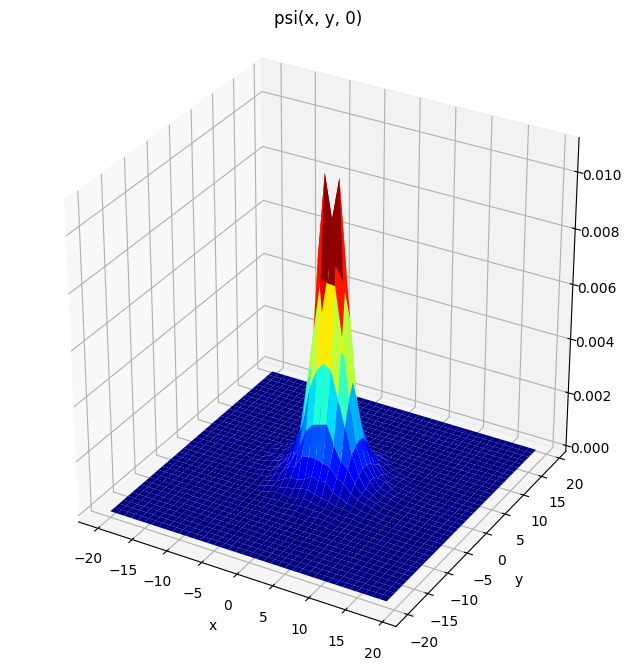

In [28]:
# plot external potential Vext(x,y,0) - surface plot

import time
import numpy as np
import matplotlib.pyplot as plt

loaded_data = np.load('js096_data.npy')
# loaded_data = np.array([ vextArray, densityArray ])
W = loaded_data

nx, ny, nz = W.shape
Wave2d = W[ : , : , int(nz/2) ]

# density field / surface plot with adjusted aspect ratio
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

# Plot the surface
x = np.arange(-nx/2,nx/2)
y = np.arange(-ny/2,ny/2)
X, Y = np.meshgrid(x, y)
Z = Wave2d.T
ax.plot_surface(X,Y,Z, cmap='jet')

# Adjust aspect ratio
ax.set_box_aspect([1, 1, 1])  # [x, y, z] aspect ratios

plt.xlabel("x")
plt.ylabel("y")
plt.title("psi(x, y, 0)")
plt.show()